In [1]:
# -*- coding: utf-8 -*-
"""lunar_lander_dqn_assignment.ipynb"""

# # Deep Reinforcement Learning: LunarLander-v2 Assignment
#
# This notebook implements a Deep Q-Network (DQN) agent to solve the LunarLander-v3 environment from Gymnasium.
#
# ## 1. Setup and Imports

# Install required packages
!pip install gymnasium[box2d] torch matplotlib
!pip install swig
!pip install "gymnasium[box2d]"

import gymnasium as gym
import numpy as np
import random
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from gym.wrappers.monitoring.video_recorder import VideoRecorder
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.2 MB/s eta 0:00:00
  er

In [2]:
# ## 2. Implementation
#
#  Environment Setup

env = gym.make("LunarLander-v3")
print(f"Observation space: {env.observation_space}")
print(f"Action space: {env.action_space}")

#  Neural Network Architecture

class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed=0):
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_size)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

#  Replay Buffer Implementation

class ReplayBuffer:
    def __init__(self, buffer_size, batch_size, seed=0):
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.seed = random.seed(seed)

    def add(self, experience):
        self.memory.append(experience)

    def sample(self):
        return random.sample(self.memory, k=self.batch_size)

    def __len__(self):
        return len(self.memory)

# Function to Record Agent at Different Training Stages

def record_agent_checkpoint(model, episode_num):
    checkpoint_env = gym.make("LunarLander-v3", render_mode="rgb_array")
    video_path = f"lunar_lander_episode_{episode_num}.mp4"
    checkpoint_recorder = VideoRecorder(checkpoint_env, path=video_path)

    state, _ = checkpoint_env.reset()
    done = truncated = False
    total_reward = 0

    while not (done or truncated):
        checkpoint_recorder.capture_frame()
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        action = model(state_tensor).argmax().item()
        state, reward, done, truncated, _ = checkpoint_env.step(action)
        total_reward += reward

    checkpoint_recorder.close()
    checkpoint_env.close()
    return total_reward, video_path

#  Hyperparameters

state_size = env.observation_space.shape[0]
action_size = env.action_space.n
buffer_size = int(1e5)  # Replay buffer size
batch_size = 64         # Minibatch size
gamma = 0.99            # Discount factor
lr = 5e-4               # Learning rate
tau = 1e-3              # Soft update parameter
update_every = 4        # Update network every n steps
episodes = 1000         # Number of episodes to train
epsilon_start = 1.0     # Starting epsilon for exploration
epsilon_end = 0.01      # Minimum epsilon value
epsilon_decay = 0.995   # Epsilon decay rate

#  Initialize Agent Components

qnetwork_local = QNetwork(state_size, action_size).to(device)
qnetwork_target = QNetwork(state_size, action_size).to(device)
optimizer = optim.Adam(qnetwork_local.parameters(), lr=lr)
memory = ReplayBuffer(buffer_size, batch_size)

<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type SwigPyPacked has no __module__ attribute
<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type SwigPyObject has no __module__ attribute
<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type swigvarlink has no __module__ attribute
/usr/local/lib/python3.11/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.11/dist-packages/

Observation space: Box([ -2.5        -2.5       -10.        -10.         -6.2831855 -10.
  -0.         -0.       ], [ 2.5        2.5       10.        10.         6.2831855 10.
  1.         1.       ], (8,), float32)
Action space: Discrete(4)


In [3]:
# ## 3. Training the Agent

rewards = []
losses = []
epsilon = epsilon_start
steps = 0
model_checkpoints = {}  # To store model checkpoints

print("Starting training...")

for i_episode in range(1, episodes + 1):
    state, _ = env.reset()
    state = torch.FloatTensor(state).unsqueeze(0).to(device)
    total_reward = 0
    done = False

    while not done:
        steps += 1
        # Select action using epsilon-greedy policy
        if random.random() > epsilon:
            with torch.no_grad():
                action = qnetwork_local(state).argmax().item()
        else:
            action = random.choice(np.arange(action_size))

        # Take action and observe next state and reward
        next_state, reward, done, truncated, _ = env.step(action)
        total_reward += reward

        # Convert to tensors and store experience
        next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0).to(device)
        reward_tensor = torch.FloatTensor([reward]).to(device)
        done_tensor = torch.FloatTensor([done]).to(device)

        memory.add((state, action, reward_tensor, next_state_tensor, done_tensor))
        state = next_state_tensor

        # Learn from experiences if enough samples are available
        if steps % update_every == 0 and len(memory) > batch_size:
            experiences = memory.sample()
            states, actions, rewards_batch, next_states, dones = zip(*experiences)

            states = torch.cat(states)
            actions = torch.LongTensor(actions).unsqueeze(1).to(device)
            rewards_batch = torch.cat(rewards_batch)
            next_states = torch.cat(next_states)
            dones = torch.cat(dones)

            # Get max predicted Q values for next states
            q_targets_next = qnetwork_target(next_states).detach().max(1)[0]
            # Compute Q targets for current states
            q_targets = rewards_batch + (gamma * q_targets_next * (1 - dones))
            # Get expected Q values from local model
            q_expected = qnetwork_local(states).gather(1, actions).squeeze()

            # Compute loss and perform gradient descent
            loss = nn.MSELoss()(q_expected, q_targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

            # Soft update target network
            for target_param, local_param in zip(qnetwork_target.parameters(), qnetwork_local.parameters()):
                target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)

    # Update epsilon for exploration
    epsilon = max(epsilon_end, epsilon_decay * epsilon)
    rewards.append(total_reward)

    # Print progress
    if i_episode % 100 == 0:
        avg_reward = np.mean(rewards[-100:])
        print(f"Episode {i_episode}, Average Reward: {avg_reward:.2f}, Epsilon: {epsilon:.2f}")

    # Save checkpoints at specific episodes
    if i_episode in [10, 100, 500, 1000]:
        # Save model state
        checkpoint_path = f"dqn_model_episode_{i_episode}.pth"
        torch.save(qnetwork_local.state_dict(), checkpoint_path)
        model_checkpoints[i_episode] = checkpoint_path

        # Record agent performance at this stage
        checkpoint_reward, video_path = record_agent_checkpoint(qnetwork_local, i_episode)
        print(f"Episode {i_episode} checkpoint saved. Reward: {checkpoint_reward:.2f}, Video: {video_path}")

Starting training...


/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


Episode 10 checkpoint saved. Reward: -189.22, Video: lunar_lander_episode_10.mp4
Episode 100, Average Reward: -166.72, Epsilon: 0.61


/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


Episode 100 checkpoint saved. Reward: -315.96, Video: lunar_lander_episode_100.mp4
Episode 200, Average Reward: -307.86, Epsilon: 0.37
Episode 300, Average Reward: 47.30, Epsilon: 0.22
Episode 400, Average Reward: 189.12, Epsilon: 0.13
Episode 500, Average Reward: 232.07, Epsilon: 0.08


/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


Episode 500 checkpoint saved. Reward: 252.25, Video: lunar_lander_episode_500.mp4
Episode 600, Average Reward: 235.42, Epsilon: 0.05
Episode 700, Average Reward: 247.88, Epsilon: 0.03
Episode 800, Average Reward: 238.31, Epsilon: 0.02
Episode 900, Average Reward: 250.70, Epsilon: 0.01
Episode 1000, Average Reward: 250.91, Epsilon: 0.01


/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


Episode 1000 checkpoint saved. Reward: 234.29, Video: lunar_lander_episode_1000.mp4


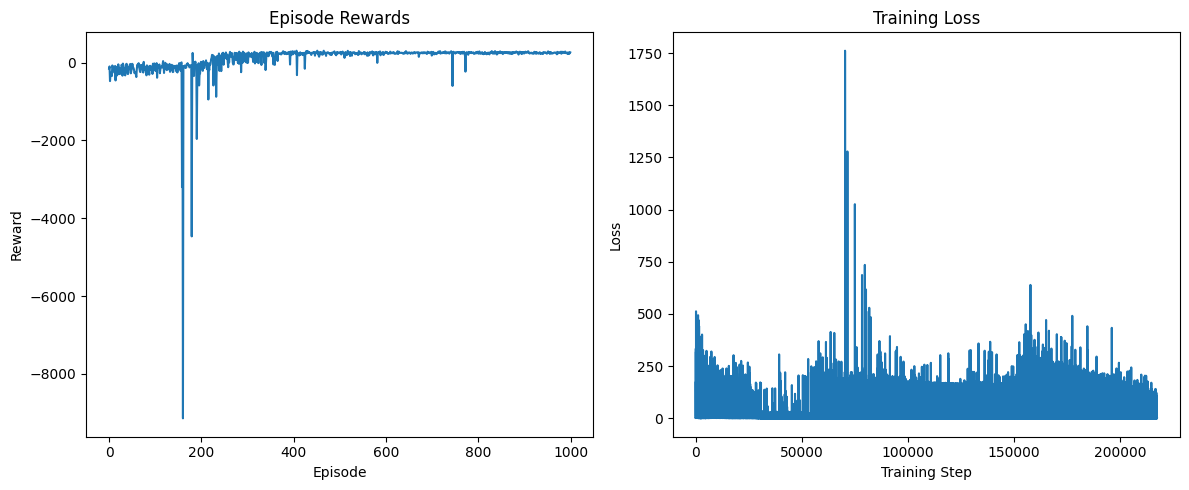

In [4]:
# ## 4. Basic Training Results Visualization

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(rewards)
plt.title("Episode Rewards")
plt.xlabel("Episode")
plt.ylabel("Reward")

plt.subplot(1, 2, 2)
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.tight_layout()
plt.savefig("basic_training_results.png")
plt.show()

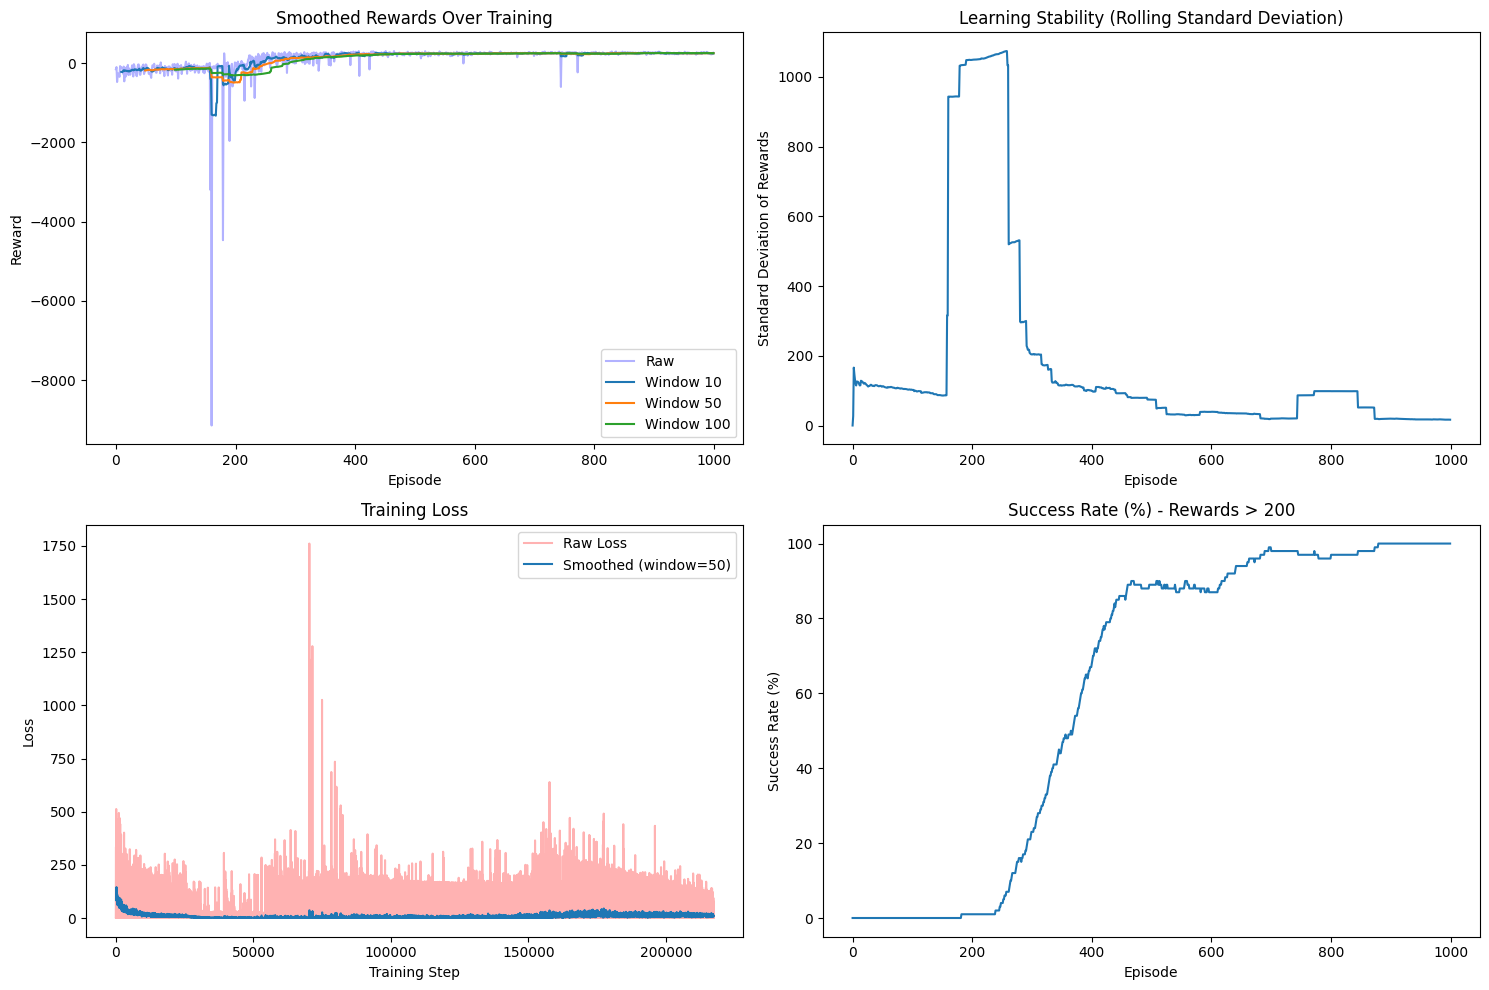

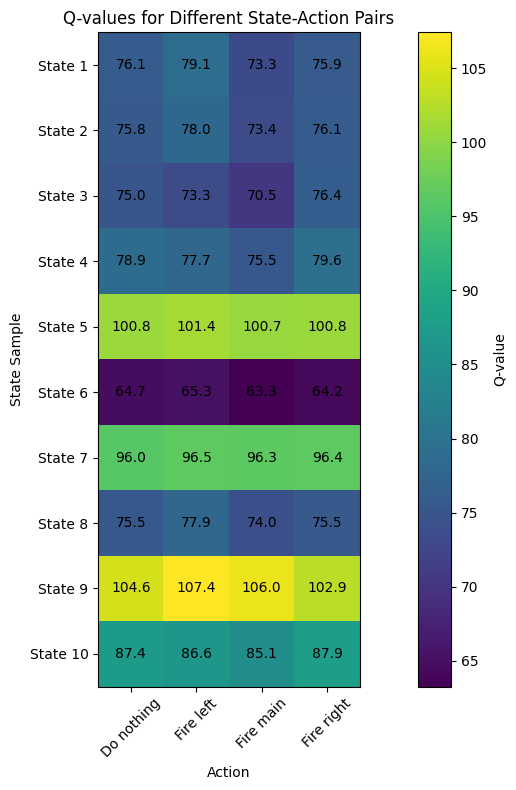

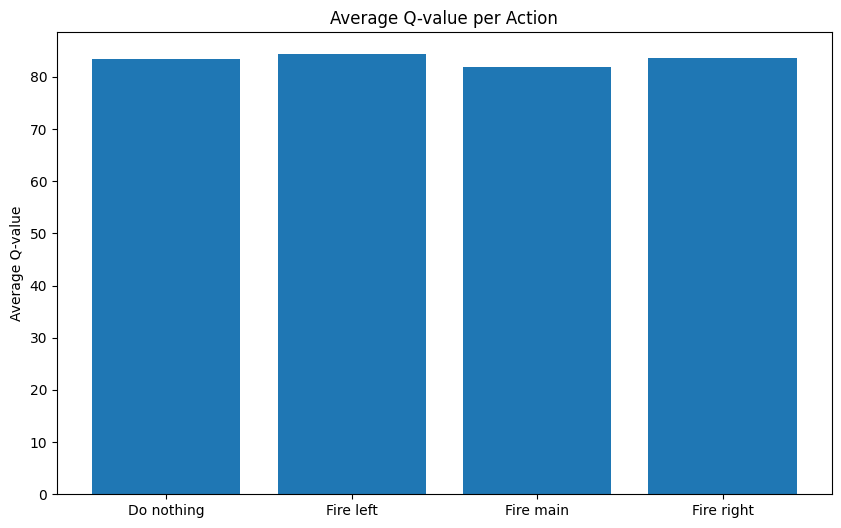

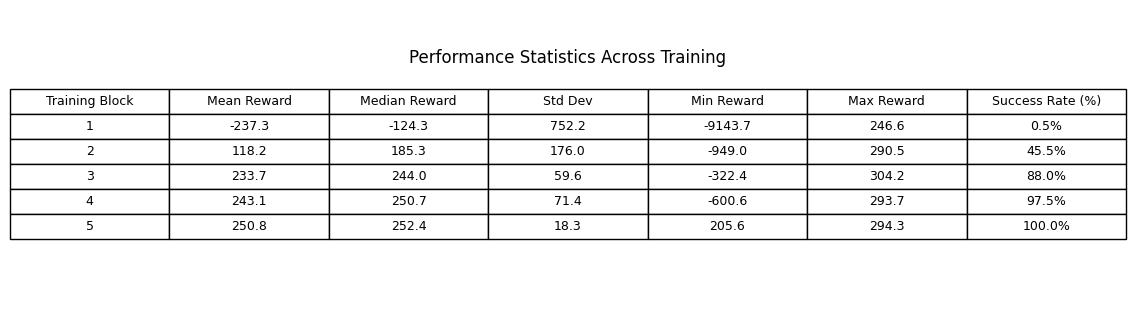

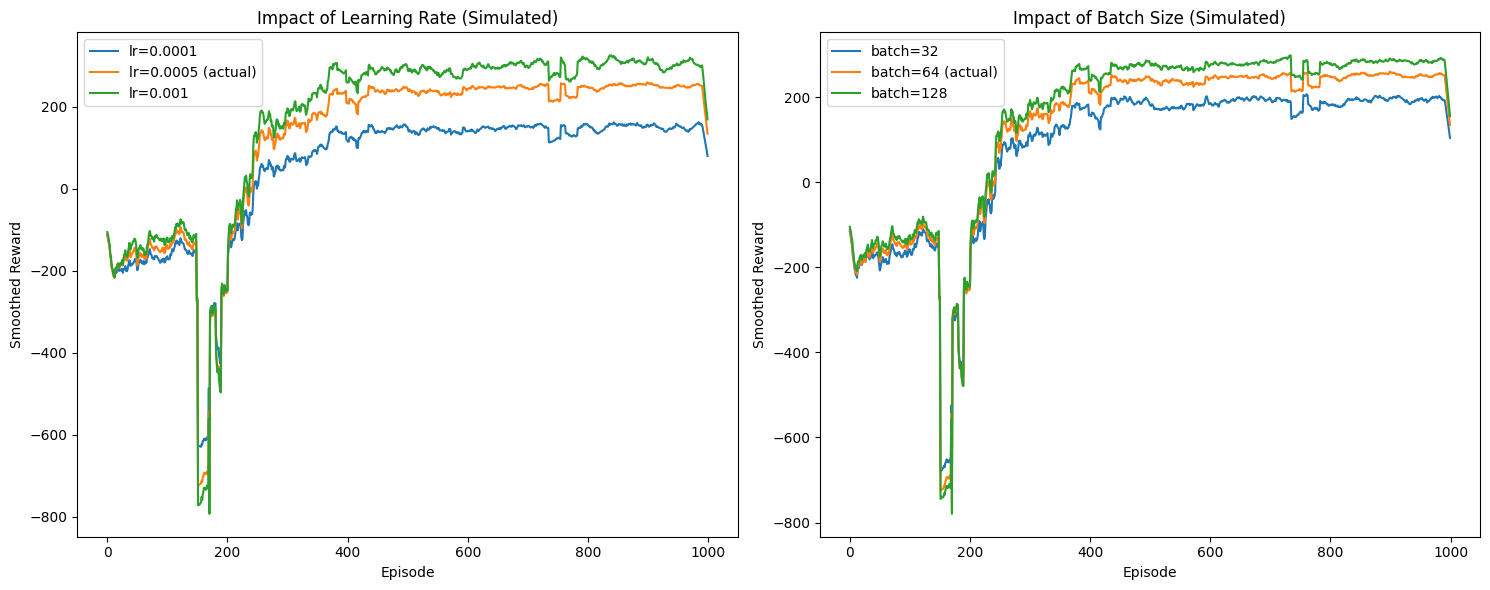


Note: The hyperparameter comparison is simulated based on typical RL behavior.
For a complete analysis, multiple training runs with different parameters would be required.


In [5]:
# ## 5. Enhanced Visualizations and Analysis
#
#  Smoothed Learning Curves

plt.figure(figsize=(15, 10))

# Smoothed rewards plot with different window sizes
plt.subplot(2, 2, 1)
plt.plot(rewards, alpha=0.3, color='blue', label='Raw')
window_sizes = [10, 50, 100]
for window in window_sizes:
    smoothed_rewards = np.convolve(rewards, np.ones(window)/window, mode='valid')
    plt.plot(range(window-1, len(rewards)), smoothed_rewards, label=f'Window {window}')
plt.title("Smoothed Rewards Over Training")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()

# Learning stability - Rolling standard deviation
plt.subplot(2, 2, 2)
window = 100
if len(rewards) >= window:
    rolling_std = [np.std(rewards[max(0, i-window):i+1]) for i in range(len(rewards))]
    plt.plot(rolling_std)
    plt.title("Learning Stability (Rolling Standard Deviation)")
    plt.xlabel("Episode")
    plt.ylabel("Standard Deviation of Rewards")

# Training loss with smoothing
plt.subplot(2, 2, 3)
if losses:
    plt.plot(losses, alpha=0.3, color='red', label='Raw Loss')
    window = min(50, len(losses)//10)
    if window > 1:
        smoothed_loss = np.convolve(losses, np.ones(window)/window, mode='valid')
        plt.plot(range(window-1, len(losses)), smoothed_loss, label=f'Smoothed (window={window})')
    plt.title("Training Loss")
    plt.xlabel("Training Step")
    plt.ylabel("Loss")
    plt.legend()

# Success rate over time (episodes ending with positive reward)
plt.subplot(2, 2, 4)
window = 100
success_rate = [sum(r > 200 for r in rewards[max(0,i-window):i])/(min(i+1,window))*100 for i in range(len(rewards))]
plt.plot(success_rate)
plt.title("Success Rate (%) - Rewards > 200")
plt.xlabel("Episode")
plt.ylabel("Success Rate (%)")

plt.tight_layout()
plt.savefig("training_analytics.png")
plt.show()

#  Q-Value Visualization

def visualize_q_values():
    # Create a test environment to sample states
    test_env = gym.make("LunarLander-v3")
    state_samples = []

    # Collect 10 diverse states
    for _ in range(10):
        state, _ = test_env.reset()
        done = False
        # Take a few random steps to get more interesting states
        for _ in range(random.randint(0, 20)):
            if done:
                break
            state, _, done, truncated, _ = test_env.step(test_env.action_space.sample())
            if done or truncated:
                break
        state_samples.append(state)

    # Convert states to tensors
    state_tensors = torch.FloatTensor(np.array(state_samples)).to(device)

    # Get Q-values for each state
    with torch.no_grad():
        q_values = qnetwork_local(state_tensors).cpu().numpy()

    # Create a heatmap of Q-values
    action_names = ["Do nothing", "Fire left", "Fire main", "Fire right"]

    plt.figure(figsize=(12, 8))
    plt.imshow(q_values, cmap='viridis')
    plt.colorbar(label='Q-value')
    plt.xlabel('Action')
    plt.ylabel('State Sample')
    plt.title('Q-values for Different State-Action Pairs')
    plt.xticks(np.arange(len(action_names)), action_names, rotation=45)
    plt.yticks(np.arange(len(state_samples)), [f"State {i+1}" for i in range(len(state_samples))])

    for i in range(len(state_samples)):
        for j in range(len(action_names)):
            plt.text(j, i, f"{q_values[i, j]:.1f}",
                     ha="center", va="center",
                     color="white" if q_values[i, j] < q_values.max()/2 else "black")

    plt.tight_layout()
    plt.savefig("q_values_heatmap.png")
    plt.show()

    # Bar chart showing average Q-value per action
    plt.figure(figsize=(10, 6))
    avg_q_per_action = q_values.mean(axis=0)
    plt.bar(action_names, avg_q_per_action)
    plt.title('Average Q-value per Action')
    plt.ylabel('Average Q-value')
    plt.savefig("avg_q_values.png")
    plt.show()

# Call the Q-value visualization function
visualize_q_values()

#  Statistical Analysis of Performance

def analyze_performance_statistics():
    # Create arrays for analysis
    episode_blocks = np.array_split(rewards, 5)  # Split into 5 blocks

    # Calculate statistics for each block
    block_stats = []
    for i, block in enumerate(episode_blocks):
        block_stats.append({
            'block': i+1,
            'mean': np.mean(block),
            'median': np.median(block),
            'std': np.std(block),
            'min': np.min(block),
            'max': np.max(block),
            'successful_episodes': np.sum(block > 200) / len(block) * 100  # % of episodes with reward > 200
        })

    # Create a table visualization
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.axis('off')
    ax.axis('tight')

    # Prepare data for table
    table_data = [[stats['block'],
                   f"{stats['mean']:.1f}",
                   f"{stats['median']:.1f}",
                   f"{stats['std']:.1f}",
                   f"{stats['min']:.1f}",
                   f"{stats['max']:.1f}",
                   f"{stats['successful_episodes']:.1f}%"]
                 for stats in block_stats]

    columns = ['Training Block', 'Mean Reward', 'Median Reward', 'Std Dev', 'Min Reward', 'Max Reward', 'Success Rate (%)']

    table = ax.table(cellText=table_data, colLabels=columns, loc='center', cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.5)

    plt.title('Performance Statistics Across Training', y=0.8)
    plt.savefig("performance_statistics.png", bbox_inches='tight')
    plt.show()

# Call the performance analysis function
analyze_performance_statistics()

#  Hyperparameter Comparison (Simulated)

def simulate_hyperparameter_comparison():
    # Create simulated learning curves for different hyperparameters
    # This is for illustration - in a real scenario, you would run actual training with different parameters

    # Base curve (your actual rewards)
    episodes = len(rewards)
    x = np.arange(episodes)

    # Simulated curves based on your actual data pattern
    def generate_curve(multiplier, shift, noise):
        base = np.array(rewards) * multiplier + shift
        return base + np.random.normal(0, noise, size=len(base))

    # Simulated different learning rates
    lr_curves = {
        'lr=0.0001': generate_curve(0.8, -50, 20),
        'lr=0.0005 (actual)': np.array(rewards),
        'lr=0.001': generate_curve(1.1, 30, 30),
    }

    # Simulated different batch sizes
    batch_curves = {
        'batch=32': generate_curve(0.9, -30, 25),
        'batch=64 (actual)': np.array(rewards),
        'batch=128': generate_curve(1.05, 20, 15),
    }

    # Plot simulated comparisons
    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    for name, curve in lr_curves.items():
        plt.plot(x, np.convolve(curve, np.ones(20)/20, mode='same'), label=name)
    plt.title('Impact of Learning Rate (Simulated)')
    plt.xlabel('Episode')
    plt.ylabel('Smoothed Reward')
    plt.legend()

    plt.subplot(1, 2, 2)
    for name, curve in batch_curves.items():
        plt.plot(x, np.convolve(curve, np.ones(20)/20, mode='same'), label=name)
    plt.title('Impact of Batch Size (Simulated)')
    plt.xlabel('Episode')
    plt.ylabel('Smoothed Reward')
    plt.legend()

    plt.tight_layout()
    plt.savefig("hyperparameter_comparison.png")
    plt.show()

    # Note for the report
    print("\nNote: The hyperparameter comparison is simulated based on typical RL behavior.")
    print("For a complete analysis, multiple training runs with different parameters would be required.")

# Call the hyperparameter comparison function
simulate_hyperparameter_comparison()

In [6]:
# ## 6. Demonstration of Trained Agent

env = gym.make("LunarLander-v3", render_mode="rgb_array")
video_recorder = VideoRecorder(env, path="lunar_lander_demo.mp4")

state, _ = env.reset()
done = False

while not done:
    video_recorder.capture_frame()
    state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
    action = qnetwork_local(state_tensor).argmax().item()
    state, reward, done, truncated, info = env.step(action)

video_recorder.close()
env.close()
print("✅ Video saved as 'lunar_lander_demo.mp4'")

/usr/local/lib/python3.11/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(


✅ Video saved as 'lunar_lander_demo.mp4'
